# Solving the many-electron Schrodinger Equation numerically

$\renewcommand{\vec}[1]{\mathbf{#1}}$

## Systems

- H atom
- He ion
- He
- H2O

## Methods

HF + DFT

## Motion

Geometry + MD

## Visualisation

wavefunctions
densities...

## something more? 

periodic?
NaCl + water


You have seen the Hartree-Fock equations introduced in Nanophysics. 

They give a way to solve the Schrodinger equation accounting for the electron-electron interaction within a mean-field approximation. That is, we do not account for where the electrons actually are relative to each other at any instant instead we just allow the electron to interact with the average distribution of the other electrons. 

Going beyond the mean-field introduces *correlation* into the motion of the different electrons - and get increasingly complicated.

## Hartree-Fock equations

the many-body wavefunction in HF is given by

$$
\Psi(\vec{x}_i, \vec{x}_2, \ldots \vec{x}_N) = \frac{1}{\sqrt{N_e!}} \begin{vmatrix}
\psi_1(\vec{x}_1) & \psi_2(\vec{x}_1) &\cdots & \psi_{N/2}(\vec{x}_1) \\
\psi_1(\vec{x}_2) & \psi_2(\vec{x}_2) &\cdots & \psi_{N/2}(\vec{x}_2) \\
\vdots & \vdots & \vdots & \vdots \\
\psi_1(\vec{x}_N) & \psi_2(\vec{x}_N) &\cdots & \psi_{N/2}(\vec{x}_N) \\
\end{vmatrix}
$$

We plug this *ansatz* into the many-body Hamiltonian and chug through a bunch of tedious calculations (see notes), introduce a basis set and and eventually it emerges that

$\vec{FC} = \vec{SCE}$

i.e. a set of matrix equations called the Roothaan-Hall equations.

## Roothaan-Hall equations

the Hartree-Fock equations are a set of non-linear integro-differential equations to be solved subject to a set of conditions (correct number of electrons and orthogonal wave-functions). This is essentially impossible to treat analytically.

We can make progress by introducing *basis functions* into the system of equations and, using a trick we used to develop a tight-binding model in Condensed Matter Physics, move from differential equations to matrix equations.

To do this we will need to introduce *matrix elements* of the basis functions with respect to each other and of the Hartree-Fock functional.

### Approximations

Fundamental approximations that we are going to introduce:

- Born-Oppenheimer approximation separating motion of nuclei and electrons;
- Independent electron approximation: write our many-body wavefunction as *single determinant* built up of single particle wavefunctions;
- Write our single particle functions as Linear Combination of Atomic Orbitals (basis-functions)

## Solving the Roothaan-Hall equations using PYSCF

PYSCF is a python library for solving the many-body Schrodinger equation. It has many methods but includes Hartree-Fock method as a starting point for many of them.

The website fro PySCF is https://pyscf.org/index.html

In [1]:
# we can access submodules from pyscf like this
import matplotlib.pyplot as plt
import numpy as np
import pyscf

As a super quick example let's run a HF model of a water molecule

In [2]:
# here we create a H2O molecule and run a HF calculation on it using a minimal basis set (STO3G)
mol_h2o = pyscf.gto.M(atom = 'O 0 0 0; H 0 1 0; H 0 0 1', basis = 'cc-pVDZ')

`mol_h2o` now is our atomistic model of the water molecule.

In [3]:
rhf_h2o = pyscf.scf.RHF(mol_h2o)
e_h2o_DZ = rhf_h2o.kernel()

converged SCF energy = -76.0167894720692


### Converging basis sets

In principle, the basis sets used are approximations and we should be able to estimate how well we are doing - we can increase the quality of the basis sets by using more gaussian functions allowing more flexibility in the variational solution of the HF equations:

In [4]:
my_basis_sets = ['cc-pVDZ', 'cc-pVTZ', 'cc-pVQZ', 'cc-pV5Z']
energy = []
for basis in my_basis_sets:
    mol_h2o = pyscf.gto.M(atom = 'O 0 0 0; H 0 1 0; H 0 0 1', basis = basis)
    rhf_h2o = pyscf.scf.RHF(mol_h2o)
    energy.append(rhf_h2o.kernel())

converged SCF energy = -76.0167894720692
converged SCF energy = -76.0456257970043
converged SCF energy = -76.0530065175422
converged SCF energy = -76.0551821620884


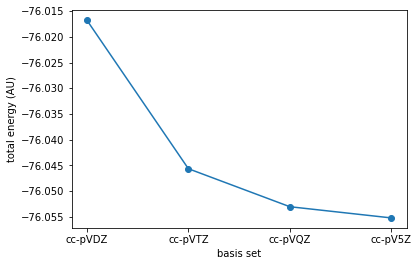

In [5]:
plt.scatter(my_basis_sets,energy)
plt.plot(my_basis_sets,energy)
plt.xlabel('basis set')
plt.ylabel('total energy (AU)');

# What is going on numerically?

we can dig deeper into PySCF and extract the matrix representation of the Schrodinger equation and see numerically what some of the constituents are: 

In [6]:
import numpy as np
from pyscf import ao2mo

mol_h2o = pyscf.gto.M(atom = 'O 0 0 0; H 0 1 0; H 0 0 1', basis = 'sto3G')

# get the overlap matrix
overlap = mol_h2o.intor('int1e_ovlp') 

# get the one-electron terms - kinetic energy and electron nuclear interaction
hkinetic = mol_h2o.intor('int1e_kin') 
hnuc = mol_h2o.intor_symmetric('int1e_nuc')

# get the two-electron terms - electron-electron repulsion elements
eri_4fold_ao = mol_h2o.intor('int2e_sph')

In [7]:
# check the shape of the matrices
hkinetic.shape, eri_4fold_ao.shape

((7, 7), (7, 7, 7, 7))

In [8]:
print(hkinetic)

[[ 2.90031999e+01 -1.68010939e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -5.12015832e-03 -5.12015832e-03]
 [-1.68010939e-01  8.08127955e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.09023173e-01  1.09023173e-01]
 [ 0.00000000e+00  0.00000000e+00  2.52873120e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.52873120e+00
   0.00000000e+00  2.52392544e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   2.52873120e+00  0.00000000e+00  2.52392544e-01]
 [-5.12015832e-03  1.09023173e-01  0.00000000e+00  2.52392544e-01
   0.00000000e+00  7.60031884e-01  1.80967253e-02]
 [-5.12015832e-03  1.09023173e-01  0.00000000e+00  0.00000000e+00
   2.52392544e-01  1.80967253e-02  7.60031884e-01]]


In [9]:
print(hnuc)

[[-6.16768093e+01 -7.43359610e+00  0.00000000e+00 -1.42231889e-02
  -1.42231889e-02 -1.57330366e+00 -1.57330366e+00]
 [-7.43359610e+00 -1.00996038e+01  0.00000000e+00 -1.69721860e-01
  -1.69721860e-01 -3.59672783e+00 -3.59672783e+00]
 [ 0.00000000e+00  0.00000000e+00 -9.95087124e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.42231889e-02 -1.69721860e-01  0.00000000e+00 -1.00640216e+01
   0.00000000e+00 -2.74859516e+00 -6.09772963e-02]
 [-1.42231889e-02 -1.69721860e-01  0.00000000e+00  0.00000000e+00
  -1.00640216e+01 -6.09772963e-02 -2.74859516e+00]
 [-1.57330366e+00 -3.59672783e+00  0.00000000e+00 -2.74859516e+00
  -6.09772963e-02 -5.70193488e+00 -1.77459817e+00]
 [-1.57330366e+00 -3.59672783e+00  0.00000000e+00 -6.09772963e-02
  -2.74859516e+00 -1.77459817e+00 -5.70193488e+00]]


In [10]:
print(overlap)

[[1.         0.23670394 0.         0.         0.         0.04875181
  0.04875181]
 [0.23670394 1.         0.         0.         0.         0.44714688
  0.44714688]
 [0.         0.         1.         0.         0.         0.
  0.        ]
 [0.         0.         0.         1.         0.         0.37820346
  0.        ]
 [0.         0.         0.         0.         1.         0.
  0.37820346]
 [0.04875181 0.44714688 0.         0.37820346 0.         1.
  0.28990152]
 [0.04875181 0.44714688 0.         0.         0.37820346 0.28990152
  1.        ]]


# Other systems

In [11]:
# here we create a H2O molecule and run a HF calculation on it using a minimal basis set (STO3G)
atom_he = pyscf.gto.M(atom = 'He 0 0 0', basis = 'sto3g')

In [12]:
# get the one-electron terms - kinetic energy and electron nuclear interaction
he_kin = atom_he.intor('int1e_kin') 
he_nuc = atom_he.intor_symmetric('int1e_nuc')

# get the two-electron terms - electron-electron repulsion elements
he_eri = atom_he.intor('int2e_sph')

In [13]:
he_overlap = atom_he.intor('int1e_ovlp') 
he_overlap

array([[1.]])

In [14]:
he_core = he_kin[0][0]+ he_nuc[0][0]

In [15]:
he_core*27.2113845

-52.56554983397122

In [16]:
rhf_he = pyscf.scf.RHF(atom_he)
e_he = rhf_he.kernel()

converged SCF energy = -2.80778395753997


In [17]:
atom_h = pyscf.gto.M(atom = 'H 0 0 0', basis = 'sto3g', spin = 1)
h_kin = atom_h.intor('int1e_kin') 
h_nuc = atom_h.intor_symmetric('int1e_nuc')
h_core = h_kin[0][0]+ h_nuc[0][0]

In [18]:
h_core*27.2113845

-12.696338109024174

In [19]:
uhf_h = pyscf.scf.UHF(atom_h)
e_h = uhf_h.kernel()

converged SCF energy = -0.466581849557275  <S^2> = 0.75  2S+1 = 2


you can also set `charge` and other properties on your 'molecule'

## Getting forces from PySCF

as well as calculating the electronic structure we can calculate the forces on the nucelei from all the electrons and the other nuclei. These forces can then be used to move the atom to find favourable molecular geometries and / or to run molecular dynamics simulations. 

We can get the forces from a particular molecular configuration (like mol_h20 we created earlier) using the 
`mol.nuc_grad_method().grad_nuc()`

In [16]:
grad = mol_h2o.nuc_grad_method().grad_nuc()
grad

converged SCF energy = -74.9611711378677


array([[ 0.        ,  2.24022816,  2.24022816],
       [ 0.        , -2.3392332 ,  0.09900503],
       [ 0.        ,  0.09900503, -2.3392332 ]])

This is just an array of force vectors - just like we had in our MD code before. 

Once we have that we can update positions etc exactly as if we were using a classical forcefield (like LJ for instance).